# **Project work: Title**

**Module:** Image and Signal Processing (ISP-AD23-FS25)  
**Authors:** Hädener Anja, Heini Sara, Huber Yeji       
**Date:** 14.05.2025


## **Introduction**

**What problem are you addressing, and why is it relevant?**     

In pharmaceutical manufacturing, especially during the production of pre-filled syringes and similar medical devices, visual inspection for quality control is a mandatory and highly critical step. Currently, this process is carried out manually by trained personnel who inspect each syringe for potential defects such as air bubbles, foreign particles, or missing liquid content.     
However, manual inspection poses several challenges: it requires significant training time, is susceptible to human error, and leads to rapid visual fatigue. In real-world operations, inspectors typically need to take a break after 30 minutes of work due to eye strain. Additionally, to maximize production efficiency, manufacturing lines often run continuously—including overnight shifts—which makes it difficult and costly to rely exclusively on human labor.     
If this process could be automated, it could address many of these issues: reducing training overhead, minimizing errors, supporting 24/7 operations, and improving overall manufacturing throughput and consistency.

**What kind of image or signal data are you working with?**     

We are working with RGB image data captured via webcam. The dataset includes images of syringes in various conditions:

(1) Reference syringes (usable)     
(2) Syringes containing air bubbles (big and small)      
(3) Syringes with foreign objects     
(4) Empty syringes  
(5) opaque liquid syringes

These images are used for both training and evaluating a classification model that determines whether a syringe is usable or defective.

**What is the main goal of your processing task?**     

The main objective of our image processing work is to build an automated system that analyzes real-time images of syringes and determines whether each syringe meets usability criteria. The system must be able to detect visual anomalies such as air bubbles, contamination, or liquid opacity. Ultimately, this system aims to support or replace human inspection in pharmaceutical quality control, enabling high-speed processing and 24-hour production while ensuring consistent accuracy.

<span style="color:#2D8FF3;font-style:italic">
<b>Instructions:</b>
Use this section to introduce and motivate your project. Provide enough context for fellow students to understand your goals.

<ul style="color:#2D8FF3">
    <li>What problem are you addressing, and why is it relevant?</li>
    <li>What kind of image or signal data are you working with?</li>
    <li>What is the main goal of your processing task?</li>
</ul>

---
## **Setup**

<span style="color:#2D8FF3;font-style:italic">
<b>Instructions:</b>
This section is about configuring the Jupyter Notebook.  
You don't need to do much here – just make sure everything runs correctly.
</span>


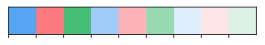

In [1]:
# Basic imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv

# Enable vectorized graphics
%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline

# Setup plotting
PALETTE = [ (0.341, 0.648, 0.962, 1.0), 
            (0.990, 0.476, 0.494, 1.0), 
            (0.281, 0.749, 0.463, 1.0), 
            (0.629, 0.802, 0.978, 1.0), 
            (0.994, 0.705, 0.715, 1.0), 
            (0.595, 0.858, 0.698, 1.0), 
            (0.876, 0.934, 0.992, 1.0), 
            (0.998, 0.901, 0.905, 1.0), 
            (0.865, 0.952, 0.899, 1.0) ]

sns.palplot(PALETTE, size=0.5)
sns.set_style("whitegrid")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=PALETTE)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["pdf.fonttype"] = 42

---
## **Implementation**

<span style="color:#2D8FF3;font-style:italic">
<b>Instructions:</b>
In this section, explain how you implemented your solution, focusing on the key processing steps and how they were translated into code. Justify your design choices and parameter settings, and describe any challenges you encountered during development. Structure this part like a tutorial to make it easy for fellow students to follow and learn from your approach.

<ul style="color:#2D8FF3">
    <li>Which key functions, algorithms, or libraries (e.g., NumPy, OpenCV, librosa, etc.) did you use?</li>
    <li>How is your processing pipeline structured? (e.g., filtering → transformation → output)</li>
    <li>Explain any relevant design decisions (e.g., kernel size, interpolation method, threshold values).</li>
    <li>If you implemented parts yourself (e.g., a filter or transform), briefly explain how.</li>
</ul>

<b>Hint:</b> To keep your code clean and modular, encapsulate your processing or feature (as well as the intermediate processing steps) into functions. See the example below for illustration.

</span>





## Implementation

To develop a robust syringe defect detection system, we designed a multi-stage processing pipeline combining machine learning and image analysis techniques. Below, we describe how we implemented this pipeline, highlighting key algorithms, design decisions, and challenges.

### 1. Key Libraries Used
1. **OpenCV (cv2)**: image preprocessing, contour and bubble detection, ROI extraction
2. **NumPy**: efficient matrix and pixel-level operations
3. **Matplotlib**: for visualizing results and debugging
4. **Scikit-learn**: training and evaluating a RandomForestClassifier
5. **TensorFlow/Keras**: training a CNN-based classifier
6. **datetime, os, glob**: for file I/O, timestamping, and automation

### 2. Processing Pipeline Structure
Our full pipeline can be summarized in three stages:

1.**ROI Detection**  →  2.**Image Preprocessing and augmentation**  →  3.**Classification (CNN)** 

1. **ROI Detection**: 
The first step of the system is to automatically detect the Region of Interest (ROI) where the syringe appears in a full image or video frame. To achieve this, the input image is first converted to grayscale, and contrast is enhanced using CLAHE (Contrast Limited Adaptive Histogram Equalization). Gaussian blur is applied to reduce noise, followed by Canny edge detection to extract clear contours. Among the detected contours, only those that are large and horizontally elongated are kept using conditions such as aspect ratio ≥ 2.0 and area ≥ 2000. These are likely to represent syringes. The selected contour is then visualized with bounding boxes (rotated or regular) and cropped into a clean ROI image. This entire process is automated and can run in real time on live video frames.

2. **Image Preprocessing and augmentation**: 
Once ROIs are extracted, the next stage is image preprocessing and augmentation to prepare the data for machine learning. All images are resized to 64×64 pixels to standardize the input size, and normalized (pixel values scaled between 0 and 1) for CNN training. Since real-world datasets are often limited, we use data augmentation to synthetically increase the dataset size. This includes rotations (0° to 330°), horizontal/vertical flips, brightness adjustments, Gaussian noise addition, blur effects, contrast changes, and combinations of these. This allows each original image to be transformed into dozens of unique variations. As a result, the model becomes more robust to real-world variations such as lighting changes, orientation, blur, and noise.

3. **Classification (CNN)**: 
After preprocessing and augmentation, the data is fed into a defect classification model — either a Random Forest (RF) or a Convolutional Neural Network (CNN).
The Random Forest model is a simple, fast classifier that takes flattened image vectors (64×64 = 4096 features) as input. It is well-suited for quick testing and early-stage evaluation but cannot capture spatial patterns effectively.
For more complex learning, we use a CNN built using Keras. The CNN consists of multiple convolutional and pooling layers that extract spatial features such as edges and textures, followed by dense and dropout layers for classification. The model is trained using the categorical cross-entropy loss function and the Adam optimizer over approximately 15 epochs. Input data is reshaped to (64, 64, 1) and normalized beforehand. 

### 3. Design Decisions and Parameters
Several parameter choices and design decisions were made based on testing, visual inspection, and expected properties of syringe images:
1. **CLAHE Settings**: `clipLimit = 3.0, tileGridSize = (8, 8)` 
  Used to enhance local contrast in grayscale images. These settings were tuned to highlight syringe edges without over-amplifying noise from the phone camera or reflections.

2. **Gaussian blur kernel size**: `Kernel size: (7, 7)` 
  A relatively large blur kernel was used during edge detection (preprocess_frame()) to reduce high-frequency noise while preserving overall syringe shape. This was particularly helpful with detailed input from mobile cameras.

3. **Canny Edge Detection**: `Thresholds: 40 and 120` 
  These values were chosen to balance sensitivity and specificity. A lower threshold (40) ensures weak syringe edges aren’t missed, while the higher one (120) prevents detecting unnecessary details like faint background texture.

4. **Contour Filtering**: `min_area = 2000, aspect_ratio ≥ 2.0` 
  Ensures that only large, horizontally-elongated objects (like syringes) are extracted. These thresholds were derived experimentally to ignore small or vertical artifacts.

5. **Augmentation Parameters**: `Rotation: every 30°, total of 12 orientations, Brightness adjustment: ±25 and ±50, Noise sigma: 10, 20, 30` 
  hese values simulate realistic conditions like tilted syringes, over/under-exposure, or image sensor noise.
  
6. **CNN Architecture**: `Convolution kernel size = (3, 3), Dropout = 0.5` 
  Small kernels are typical for CNNs and allow detailed local feature extraction. Stacked layers help model increasingly abstract features. Added before the final classification layer to reduce overfitting due to repeated augmented samples.


This structure allows for easy extension, reuse, and integration of additional logic (e.g., classification, augmentation).

### 1. Key Libraries and Tools

In [2]:
from datetime import datetime
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder

### 2. Processing Pipeline Structure

#### preprocessing

In [82]:
def preprocess_frame(frame):
    # Convert to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Apply CLAHE with adjusted parameters for phone camera
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Stronger blur for phone camera's higher detail
    blur = cv.GaussianBlur(gray, (7, 7), 0)
    
    # Adjust Canny parameters for phone camera
    edges = cv.Canny(blur, 40, 120)
    
    # More aggressive dilation to connect edges
    kernel = np.ones((3,3), np.uint8)
    edges = cv.dilate(edges, kernel, iterations=2)
    
    return edges

def find_largest_contour(edges, min_area=2000, min_aspect_ratio=2.0):
    """Find the largest contour that matches horizontal syringe criteria"""
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    valid_contours = []
    for contour in contours:
        area = cv.contourArea(contour)
        if area < min_area:
            continue
            
        # Get bounding rectangle
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = w / h  # For horizontal syringes, width should be greater than height
        
        # Check if the contour is wide enough and has the right shape
        if aspect_ratio >= min_aspect_ratio:
            valid_contours.append(contour)
    
    if not valid_contours:
        return None
        
    # Return the largest valid contour
    return [max(valid_contours, key=cv.contourArea)]

def draw_bounding_boxes(frame, contours):
    if contours is None:
        return frame
        
    for cnt in contours:
        # Get rotated rectangle for better fit
        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.int32(box)
        
        # Draw rotated rectangle in green
        cv.drawContours(frame, [box], 0, (0, 255, 0), 2)
        
        # Draw regular bounding box in blue
        x, y, w, h = cv.boundingRect(cnt)
        cv.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Add text showing dimensions
        cv.putText(frame, f"Width: {w}px", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv.putText(frame, f"Height: {h}px", (x, y-25), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Add aspect ratio
        aspect_ratio = w / h
        cv.putText(frame, f"Aspect Ratio: {aspect_ratio:.2f}", (x, y-40), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
    return frame

def save_rois(frame, contours, frame_id, output_dir="detected_syringes"):
    """Save the detected regions of interest (ROIs)"""
    if contours is None:
        return
        
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    for i, cnt in enumerate(contours):
        # Get bounding rectangle
        x, y, w, h = cv.boundingRect(cnt)
        
        # Add padding around the ROI
        padding = 20
        y_start = max(0, y - padding)
        y_end = min(frame.shape[0], y + h + padding)
        x_start = max(0, x - padding)
        x_end = min(frame.shape[1], x + w + padding)
        
        # Extract ROI with padding
        roi = frame[y_start:y_end, x_start:x_end]
        
        # Save ROI with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{output_dir}/syringe_{frame_id}_{timestamp}.jpg"
        cv.imwrite(filename, roi)

#### capture images from live video

In [89]:
def run_detection():
    # Try different camera indices - Iriun often uses index 1 or 2
    camera_indices = [1]
    cap = None
    
    # Try to find the correct camera
    for idx in camera_indices:
        print(f"Trying camera index {idx}...")
        cap = cv.VideoCapture(idx)
        if cap.isOpened():
            # Try to get a frame
            ret, test_frame = cap.read()
            if ret:
                print(f"Successfully connected to camera {idx}")
                break
            else:
                cap.release()
        
    if cap is None or not cap.isOpened():
        print("Could not find Iriun camera. Make sure it's running and try again.")
        return

    # Get the actual frame size
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    print(f"Camera resolution: {frame_width}x{frame_height}")

    print("Camera is running. Press 'q' to quit, 's' to save current frame")
    print("Detecting horizontal syringes...")
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize frame if it's too large (optional, remove if you want full resolution)
        if frame_width > 1280:
            scale_factor = 1280 / frame_width
            new_width = 1280
            new_height = int(frame_height * scale_factor)
            frame = cv.resize(frame, (new_width, new_height))

        # Create a copy for display
        display_frame = frame.copy()
        
        # Process frame
        edges = preprocess_frame(frame)
        valid_contours = find_largest_contour(edges)
        
        # Draw edges for debugging
        edges_display = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
        
        if valid_contours:
            display_frame = draw_bounding_boxes(display_frame, valid_contours)
            save_rois(frame, valid_contours, frame_count)
        
        # Show both the edges and the result
        # Resize windows to fit screen if needed
        display_size = (800, 600)  # Adjust these values if needed
        edges_resized = cv.resize(edges_display, display_size)
        result_resized = cv.resize(display_frame, display_size)
        combined_display = np.hstack([edges_resized, result_resized])
        
        cv.imshow("Detection (Edges | Result)", combined_display)

        key = cv.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            # Save both the edge detection and final result
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            cv.imwrite(f"syringe_edges_{timestamp}.jpg", edges)
            cv.imwrite(f"syringe_detection_{timestamp}.jpg", display_frame)
            print(f"Saved frames with timestamp {timestamp}")

        frame_count += 1

    cap.release()
    cv.destroyAllWindows()

#### preparation of samples for model 

In [94]:
def load_dataset_crop(base_path="dataset", crop_size=(64, 64)):
    data = []
    labels = []
    crop_h, crop_w = crop_size

    for label_name in ["ok", "defect"]:
        folder = os.path.join(base_path, label_name)
        for file in os.listdir(folder):
            path = os.path.join(folder, file)
            img = cv.imread(path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue

            h, w = img.shape
            if h < crop_h or w < crop_w:
                continue  # skip if image is smaller than crop size

            y1 = (h - crop_h) // 2
            x1 = (w - crop_w) // 2
            cropped = img[y1:y1+crop_h, x1:x1+crop_w]

            data.append(cropped.flatten())
            labels.append(label_name)

    return np.array(data), np.array(labels)

In [99]:
def load_dataset(base_path="dataset", size=(64, 64)):
    data = []
    labels = []
    for label_name in ["ok", "defect"]:
        folder = os.path.join(base_path, label_name)
        for file in os.listdir(folder):
            path = os.path.join(folder, file)
            img = cv.imread(path, cv.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv.resize(img, size)
            data.append(img.flatten())
            labels.append(label_name)
    return np.array(data), np.array(labels)

In [ ]:
def augment_data(image):
    """
    Augment a single image with various transformations to multiply the dataset.
    Returns a list of augmented images.
    """
    augmented = []
    
    # augment rotations at finer angles
    for angle in range(0, 360, 30):  # Rotate every 30 degrees
        matrix = cv.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1.0)
        rotated = cv.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        augmented.append(rotated)
    
    # augment flips and combinations
    flipped_h = cv.flip(image, 1)
    flipped_v = cv.flip(image, 0)
    flipped_both = cv.flip(image, -1)
    augmented.extend([flipped_h, flipped_v, flipped_both])
    
    # augment noise levels
    for sigma in [10, 20, 30]:
        noise = np.random.normal(0, sigma, image.shape).astype(np.uint8)
        noisy = cv.add(image, noise)
        augmented.append(noisy)
    
    # augment brightness adjustments
    for delta in [-50, -25, 25, 50]:
        if delta > 0:
            adjusted = cv.add(image, delta)
        else:
            adjusted = cv.subtract(image, abs(delta))
        augmented.append(adjusted)
    
    # augment blur levels
    for kernel_size in [(3,3), (5,5), (7,7)]:
        blurred = cv.GaussianBlur(image, kernel_size, 0)
        augmented.append(blurred)
    
    # Contrast adjustments
    for alpha in [0.5, 1.5]:  # Contrast factors
        contrasted = cv.convertScaleAbs(image, alpha=alpha, beta=0)
        augmented.append(contrasted)
    
    # Combinations of transformations
    for rot_img in augmented[:3]:  # Take first few rotated images
        noise = np.random.normal(0, 15, rot_img.shape).astype(np.uint8)
        combo = cv.add(rot_img, noise)
        combo = cv.GaussianBlur(combo, (3,3), 0)
        augmented.append(combo)
    
    return augmented

#### prediction

In [90]:
def load_and_predict_randomforest(model):
    """
    Load ROI images from the detected_syringes directory and make predictions using the trained model
    
    Args:
        model: Trained classifier model
        
    Returns:
        Dictionary mapping image filenames to predictions
    """
    predictions = {}
    roi_dir = 'detected_syringes_ok'
    
    # Check if directory exists
    if not os.path.exists(roi_dir):
        print(f"Directory {roi_dir} not found")
        return None
        
    # Load and process each image
    for filename in os.listdir(roi_dir):
        if filename.endswith(('.jpg', '.png')):
            # Load image
            img_path = os.path.join(roi_dir, filename)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Could not load image: {filename}")
                continue
                
            # Resize to match training data (64x64 since model expects 4096 features)
            img_resized = cv.resize(img, (64, 64))
            
            # Flatten and normalize
            img_flat = img_resized.flatten()
            
            # Make prediction
            prediction = model.predict([img_flat])[0]
            predictions[filename] = prediction
            
            # Print individual predictions
            print(f"{filename}: {prediction}")
            
    return predictions

In [14]:
def load_and_predict_rois_cnn(model, roi_dir):
    predictions = {}
    
    if not os.path.exists(roi_dir):
        print(f"Directory '{roi_dir}' does not exist")
        return predictions
        
    for filename in os.listdir(roi_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Load and preprocess image
            img_path = os.path.join(roi_dir, filename)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            
            # Resize to match CNN input shape (64x64)
            img_resized = cv.resize(img, (64, 64))
            
            # Normalize and reshape for CNN
            img_normalized = img_resized / 255.0
            img_input = img_normalized.reshape(1, 64, 64, 1)  # Add batch and channel dimensions
            
            # Make prediction
            prediction = model.predict(img_input, verbose=0)[0]
            pred_class = "ok" if prediction[0] > 0.5 else "defect"
            predictions[filename] = pred_class
            
            # Print individual predictions
            print(f"{filename}: {pred_class}")
            
    return predictions

### 3. Model

#### Several attempts of preparation dataset

crop to 64 x 64

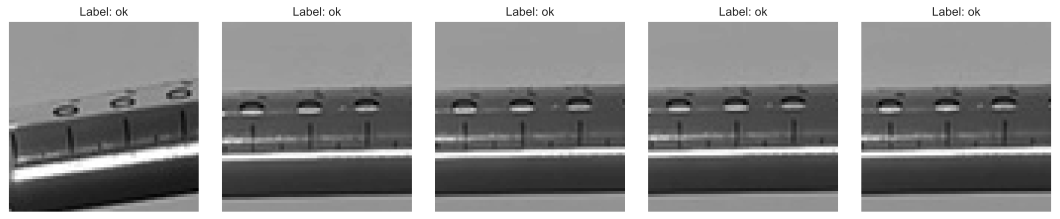

Dataset shape: (3612, 4096)
Number of samples: 3612
Number of unique labels: 2

Sample distribution:
Label defect: 2823 samples
Label ok: 789 samples


In [ ]:
# Load and display some examples from the dataset
X, y = load_dataset_crop()

# Display first 5 examples
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of unique labels: {len(np.unique(y))}")
print("\nSample distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

crop to 96 x 96

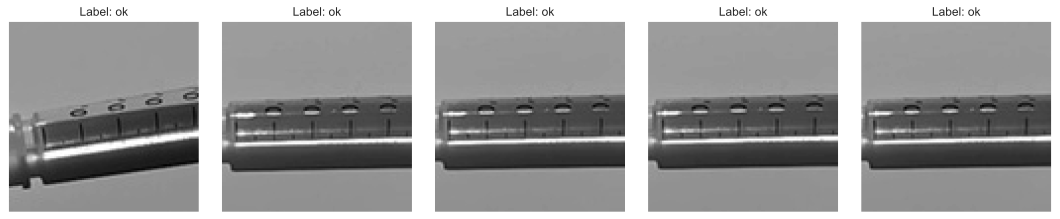

Dataset shape: (3583, 9216)
Number of samples: 3583
Number of unique labels: 2

Sample distribution:
Label defect: 2794 samples
Label ok: 789 samples


In [98]:
X, y = load_dataset_crop(crop_size=(96, 96))

# Display first 5 examples
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].reshape(96, 96), cmap='gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of unique labels: {len(np.unique(y))}")
print("\nSample distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

crop to 128 x 128

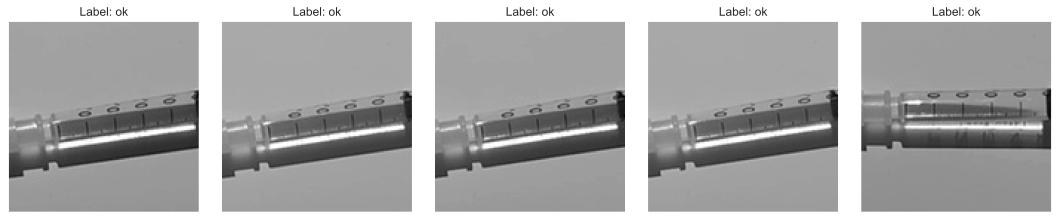

Dataset shape: (2683, 16384)
Number of samples: 2683
Number of unique labels: 2

Sample distribution:
Label defect: 2173 samples
Label ok: 510 samples


In [97]:
X, y = load_dataset_crop(crop_size=(128, 128))

# Display first 5 examples
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].reshape(128, 128), cmap='gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of unique labels: {len(np.unique(y))}")
print("\nSample distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

resize to 128 x 128

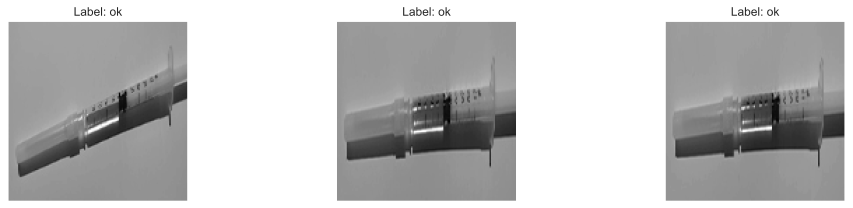

Dataset shape: (3612, 16384)
Number of samples: 3612
Number of unique labels: 2

Sample distribution:
Label defect: 2823 samples
Label ok: 789 samples


In [101]:
# Load and display some examples from the dataset
X, y = load_dataset(size=(128, 128))

# Display first 5 examples
plt.figure(figsize=(15, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X[i].reshape(128, 128), cmap='gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of unique labels: {len(np.unique(y))}")
print("\nSample distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

#### Final preparation dataset

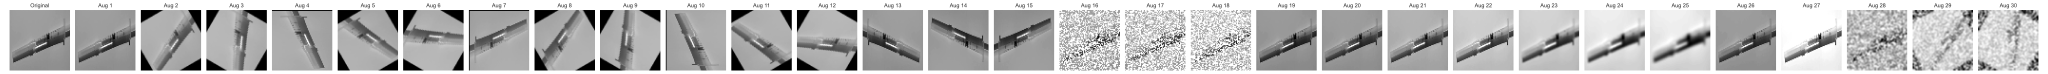

In [ ]:
# Load original dataset
X_orig, y_orig = load_dataset()

# Load and predict using the CNN model
example_img_flat = X_orig[0]
example_label = y_orig[0]

# Reshape the flat image to 2D for augmentation
example_img_2d = example_img_flat.reshape(64, 64)

# perform data augmentation
augmented_images = augment_data(example_img_2d)

# Plot the original and augmented images
n_aug = len(augmented_images)
plt.figure(figsize=(2 * (n_aug + 1), 3))

# original image
plt.subplot(1, n_aug + 1, 1)
plt.imshow(example_img_2d, cmap='gray')
plt.title("Original")
plt.axis('off')

# augmented images
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, n_aug + 1, i + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Load original dataset and augment
X_orig, y_orig = load_dataset()

# Augment data
X_augmented = []
y_augmented = []

for img, label in zip(X_orig, y_orig):
    # Reshape flattened image back to 2D
    img_2d = img.reshape(64, 64)
    
    # Add original image
    X_augmented.append(img)
    y_augmented.append(label)
    
    # Add augmented versions
    augmented_images = augment_data(img_2d)
    for aug_img in augmented_images:
        X_augmented.append(aug_img.flatten())
        y_augmented.append(label)

# Convert to numpy arrays
X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"Original dataset size: {len(X_orig)}")
print(f"Augmented dataset size: {len(X)}")

# Split augmented data into train/test sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X, y, test_size=0.2, random_state=42)

Original dataset size: 3612
Augmented dataset size: 111972


#### RandomForest Classification

In [28]:
# Train model on augmented data
clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
clf_aug.fit(X_train_aug, y_train_aug)

# Evaluate model trained on augmented data
y_pred_aug = clf_aug.predict(X_test_aug)
print("\nModel performance with augmented training data:")
print(classification_report(y_test_aug, y_pred_aug))


Model performance with augmented training data:
              precision    recall  f1-score   support

      defect       0.97      1.00      0.98     17496
          ok       1.00      0.88      0.94      4899

    accuracy                           0.97     22395
   macro avg       0.98      0.94      0.96     22395
weighted avg       0.97      0.97      0.97     22395



#### CNN

In [12]:
# Convert labels to numeric values first

label_map = {'defect': 0, 'ok': 1}  # Added 'ok' mapping to match existing labels
y_train_numeric = np.array([label_map[label] for label in y_train_aug])
y_test_numeric = np.array([label_map[label] for label in y_test_aug])

# Convert labels to categorical
y_train_cat = to_categorical(y_train_numeric)
y_test_cat = to_categorical(y_test_numeric)

# Reshape input data for CNN (add channel dimension)
X_train_reshaped = X_train_aug.reshape(-1, 64, 64, 1)
X_test_reshaped = X_test_aug.reshape(-1, 64, 64, 1)

# Normalize pixel values
X_train_normalized = X_train_reshaped / 255.0
X_test_normalized = X_test_reshaped / 255.0

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train_normalized, y_train_cat,
                    epochs=15,
                    batch_size=32,
                    validation_data=(X_test_normalized, y_test_cat))

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_cat)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

c:\Users\yejih\Documents\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 99s 35ms/step - accuracy: 0.8566 - loss: 0.3092 - val_accuracy: 0.9664 - val_loss: 0.0891
Epoch 2/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 93s 33ms/step - accuracy: 0.9616 - loss: 0.0973 - val_accuracy: 0.9783 - val_loss: 0.0533
Epoch 3/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 101s 36ms/step - accuracy: 0.9762 - loss: 0.0612 - val_accuracy: 0.9838 - val_loss: 0.0433
Epoch 4/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 99s 35ms/step - accuracy: 0.9815 - loss: 0.0456 - val_accuracy: 0.9854 - val_loss: 0.0360
Epoch 5/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 100s 36ms/step - accuracy: 0.9857 - loss: 0.0368 - val_accuracy: 0.9873 - val_loss: 0.0329
Epoch 6/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 101s 36ms/step - accuracy: 0.9884 - loss: 0.0314 - val_accuracy: 0.9901 - val_loss: 0.0259
Epoch 7/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 100s 36ms/step - accuracy: 0.9893 - loss: 0.0277 - val_accuracy: 0.9887 - val_loss: 0.0300
Epoch 8/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 102s 36ms/step - accuracy: 0.9

---

## **Results**

<span style="color:#2D8FF3;font-style:italic">
<b>Instructions:</b>
Demonstrate the outcome of your solution. This section can be brief, but should show what your implementation produces.

<ul style="color:#2D8FF3">
    <li>Use representative input and output examples to illustrate the effect of your processing.</li>
    <li>Don't limit yourself to best-case results – also show cases where the method performs poorly or struggles.</li>
</ul>
</span>




#### run camera

In [86]:
# Start detection
run_detection()

Trying camera index 1...
Successfully connected to camera 1
Camera resolution: 640x480
Camera is running. Press 'q' to quit, 's' to save current frame
Detecting horizontal syringes...


#### Test of random forest model

**with ok syringe**

In [ ]:
predictions = load_and_predict_randomforest(clf_aug)

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
    # Make final verdict based on majority
    verdict = "OK" if ok_percent > 50 else "DEFECTIVE"
    confidence = max(ok_percent, defect_percent)
    print(f"\nFinal verdict: Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")

syringe_0_20250531_171832.jpg: defect
syringe_100_20250531_171835.jpg: defect
syringe_101_20250531_171835.jpg: defect
syringe_102_20250531_171835.jpg: defect
syringe_103_20250531_171835.jpg: defect
syringe_104_20250531_171835.jpg: defect
syringe_105_20250531_171835.jpg: defect
syringe_106_20250531_171835.jpg: defect
syringe_107_20250531_171835.jpg: defect
syringe_108_20250531_171835.jpg: defect
syringe_109_20250531_171835.jpg: defect
syringe_10_20250531_171832.jpg: defect
syringe_110_20250531_171835.jpg: defect
syringe_111_20250531_171835.jpg: defect
syringe_112_20250531_171835.jpg: defect
syringe_113_20250531_171835.jpg: defect
syringe_114_20250531_171835.jpg: defect
syringe_115_20250531_171836.jpg: defect
syringe_116_20250531_171836.jpg: defect
syringe_117_20250531_171836.jpg: defect
syringe_118_20250531_171836.jpg: defect
syringe_119_20250531_171836.jpg: defect
syringe_11_20250531_171832.jpg: defect
syringe_120_20250531_171836.jpg: defect
syringe_121_20250531_171836.jpg: defect
syri

#### Test CNN model

**test with not clear syringe(Demo)**

In [87]:
# Use the CNN-specific prediction function
predictions = load_and_predict_rois_cnn(model, roi_dir='detected_syringes')

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
# Make final verdict based on defect threshold
    defect_threshold = 5.0  # 5% threshold for defects
    verdict = "DEFECTIVE" if defect_percent > defect_threshold else "OK"
    confidence = defect_percent if verdict == "DEFECTIVE" else ok_percent
    print(f"\nFinal verdict (5% defect threshold): Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")

syringe_0_20250604_115055.jpg: ok
syringe_0_20250604_115155.jpg: defect
syringe_100_20250604_115059.jpg: ok
syringe_100_20250604_115158.jpg: ok
syringe_101_20250604_115059.jpg: ok
syringe_101_20250604_115159.jpg: ok
syringe_102_20250604_115059.jpg: ok
syringe_102_20250604_115159.jpg: ok
syringe_103_20250604_115059.jpg: defect
syringe_103_20250604_115159.jpg: ok
syringe_104_20250604_115059.jpg: ok
syringe_104_20250604_115159.jpg: ok
syringe_105_20250604_115059.jpg: ok
syringe_105_20250604_115159.jpg: ok
syringe_106_20250604_115059.jpg: ok
syringe_106_20250604_115159.jpg: ok
syringe_107_20250604_115059.jpg: ok
syringe_107_20250604_115159.jpg: ok
syringe_108_20250604_115059.jpg: ok
syringe_108_20250604_115159.jpg: ok
syringe_109_20250604_115059.jpg: ok
syringe_109_20250604_115159.jpg: ok
syringe_10_20250604_115056.jpg: ok
syringe_10_20250604_115155.jpg: ok
syringe_110_20250604_115059.jpg: defect
syringe_110_20250604_115159.jpg: ok
syringe_111_20250604_115059.jpg: ok
syringe_111_20250604_1

**test with okay syringe**

In [15]:
# Use the CNN-specific prediction function
predictions = load_and_predict_rois_cnn(model, roi_dir='detected_syringes_ok')

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
# Make final verdict based on defect threshold
    defect_threshold = 5.0  # 5% threshold for defects
    verdict = "DEFECTIVE" if defect_percent > defect_threshold else "OK"
    confidence = defect_percent if verdict == "DEFECTIVE" else ok_percent
    print(f"\nFinal verdict (5% defect threshold): Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")

syringe_0_20250531_171832.jpg: ok
syringe_100_20250531_171835.jpg: ok
syringe_101_20250531_171835.jpg: ok
syringe_102_20250531_171835.jpg: ok
syringe_103_20250531_171835.jpg: ok
syringe_104_20250531_171835.jpg: ok
syringe_105_20250531_171835.jpg: ok
syringe_106_20250531_171835.jpg: ok
syringe_107_20250531_171835.jpg: ok
syringe_108_20250531_171835.jpg: ok
syringe_109_20250531_171835.jpg: ok
syringe_10_20250531_171832.jpg: ok
syringe_110_20250531_171835.jpg: ok
syringe_111_20250531_171835.jpg: ok
syringe_112_20250531_171835.jpg: ok
syringe_113_20250531_171835.jpg: ok
syringe_114_20250531_171835.jpg: ok
syringe_115_20250531_171836.jpg: ok
syringe_116_20250531_171836.jpg: ok
syringe_117_20250531_171836.jpg: ok
syringe_118_20250531_171836.jpg: ok
syringe_119_20250531_171836.jpg: ok
syringe_11_20250531_171832.jpg: ok
syringe_120_20250531_171836.jpg: ok
syringe_121_20250531_171836.jpg: ok
syringe_122_20250531_171836.jpg: ok
syringe_123_20250531_171836.jpg: ok
syringe_124_20250531_171836.jpg:

**test with detected_syringes_with_bubbles**

In [73]:
# Use the CNN-specific prediction function
predictions = load_and_predict_rois_cnn(model, roi_dir='detected_syringes_with_bubbles')

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
# Make final verdict based on defect threshold
    defect_threshold = 5.0  # 5% threshold for defects
    verdict = "DEFECTIVE" if defect_percent > defect_threshold else "OK"
    confidence = defect_percent if verdict == "DEFECTIVE" else ok_percent
    print(f"\nFinal verdict (5% defect threshold): Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")



syringe_0_20250531_171052.jpg: ok
syringe_100_20250531_171055.jpg: ok
syringe_101_20250531_171055.jpg: ok
syringe_102_20250531_171055.jpg: ok
syringe_103_20250531_171055.jpg: ok
syringe_104_20250531_171055.jpg: ok
syringe_105_20250531_171055.jpg: ok
syringe_106_20250531_171055.jpg: ok
syringe_107_20250531_171055.jpg: ok
syringe_108_20250531_171055.jpg: ok
syringe_109_20250531_171056.jpg: ok
syringe_10_20250531_171052.jpg: ok
syringe_110_20250531_171056.jpg: ok
syringe_111_20250531_171056.jpg: ok
syringe_112_20250531_171056.jpg: ok
syringe_113_20250531_171056.jpg: ok
syringe_114_20250531_171056.jpg: ok
syringe_115_20250531_171056.jpg: ok
syringe_116_20250531_171056.jpg: ok
syringe_117_20250531_171056.jpg: ok
syringe_118_20250531_171056.jpg: ok
syringe_119_20250531_171056.jpg: ok
syringe_11_20250531_171052.jpg: ok
syringe_120_20250531_171056.jpg: ok
syringe_121_20250531_171056.jpg: ok
syringe_122_20250531_171056.jpg: ok
syringe_123_20250531_171056.jpg: ok
syringe_124_20250531_171056.jpg:

**test with okay syringe**

In [74]:
# Use the CNN-specific prediction function
predictions = load_and_predict_rois_cnn(model, roi_dir = 'detected_syringes_ok2')

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
# Make final verdict based on defect threshold
    defect_threshold = 5.0  # 5% threshold for defects
    verdict = "DEFECTIVE" if defect_percent > defect_threshold else "OK"
    confidence = defect_percent if verdict == "DEFECTIVE" else ok_percent
    print(f"\nFinal verdict (5% defect threshold): Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")

syringe_0_20250602_190701.jpg: ok
syringe_100_20250602_190704.jpg: ok
syringe_101_20250602_190704.jpg: ok
syringe_102_20250602_190704.jpg: ok
syringe_103_20250602_190704.jpg: ok
syringe_104_20250602_190705.jpg: ok
syringe_105_20250602_190705.jpg: ok
syringe_106_20250602_190705.jpg: ok
syringe_107_20250602_190705.jpg: ok
syringe_108_20250602_190705.jpg: ok
syringe_109_20250602_190705.jpg: ok
syringe_10_20250602_190701.jpg: ok
syringe_110_20250602_190705.jpg: ok
syringe_111_20250602_190705.jpg: ok
syringe_112_20250602_190705.jpg: ok
syringe_113_20250602_190705.jpg: ok
syringe_114_20250602_190705.jpg: ok
syringe_115_20250602_190705.jpg: ok
syringe_116_20250602_190705.jpg: ok
syringe_117_20250602_190705.jpg: ok
syringe_118_20250602_190705.jpg: ok
syringe_119_20250602_190705.jpg: ok
syringe_11_20250602_190701.jpg: ok
syringe_120_20250602_190705.jpg: ok
syringe_121_20250602_190705.jpg: ok
syringe_122_20250602_190705.jpg: ok
syringe_123_20250602_190705.jpg: ok
syringe_124_20250602_190705.jpg:

**test with particle syringe**

In [88]:
# Use the CNN-specific prediction function
predictions = load_and_predict_rois_cnn(model, roi_dir='detected_syringes_particle')

# Print summary
if predictions:
    ok_count = sum(1 for pred in predictions.values() if pred == "ok")
    defect_count = sum(1 for pred in predictions.values() if pred == "defect")
    total = len(predictions)
    ok_percent = (ok_count / total) * 100
    defect_percent = (defect_count / total) * 100
    
    print("\nSummary:")
    print(f"Total images processed: {total}")
    print(f"OK predictions: {ok_count} ({ok_percent:.1f}%)")
    print(f"Defective predictions: {defect_count} ({defect_percent:.1f}%)")
    
# Make final verdict based on defect threshold
    defect_threshold = 5.0  # 5% threshold for defects
    verdict = "DEFECTIVE" if defect_percent > defect_threshold else "OK"
    confidence = defect_percent if verdict == "DEFECTIVE" else ok_percent
    print(f"\nFinal verdict (5% defect threshold): Syringe is {verdict}")
else:
    print("\nNo ROIs were processed. Make sure there are images in the 'detected_syringes' directory.")

syringe_0_20250602_195733.jpg: ok
syringe_100_20250602_195736.jpg: ok
syringe_101_20250602_195737.jpg: ok
syringe_102_20250602_195737.jpg: ok
syringe_103_20250602_195737.jpg: ok
syringe_104_20250602_195737.jpg: ok
syringe_105_20250602_195737.jpg: ok
syringe_106_20250602_195737.jpg: ok
syringe_107_20250602_195737.jpg: ok
syringe_108_20250602_195737.jpg: ok
syringe_109_20250602_195737.jpg: ok
syringe_10_20250602_195733.jpg: ok
syringe_110_20250602_195737.jpg: ok
syringe_111_20250602_195737.jpg: ok
syringe_112_20250602_195737.jpg: ok
syringe_113_20250602_195737.jpg: ok
syringe_114_20250602_195737.jpg: ok
syringe_115_20250602_195737.jpg: ok
syringe_116_20250602_195737.jpg: ok
syringe_117_20250602_195737.jpg: ok
syringe_118_20250602_195737.jpg: ok
syringe_119_20250602_195737.jpg: ok
syringe_11_20250602_195734.jpg: ok
syringe_120_20250602_195737.jpg: ok
syringe_121_20250602_195737.jpg: ok
syringe_122_20250602_195737.jpg: ok
syringe_123_20250602_195737.jpg: ok
syringe_124_20250602_195737.jpg:

---

## **Discussion**

<span style="color:#2D8FF3;font-style:italic">
<b>Instructions:</b>
Reflect on your results and the overall performance of your solution. This section helps you and others understand what worked well, what did not, and why.

<ul>
    <li>Interpret your results: What patterns or weaknesses did you observe?</li>
    <li>How robust is your solution to variations in the input (e.g., noise, contrast, lighting)?</li>
    <li>Were there cases where your method failed or produced unexpected results? Why?</li>
    <li>What could be improved or extended in a future version?</li>
    <li>If applicable, compare your method to alternatives or standard approaches.</li>
</ul>

Be honest and analytical – this section is not about perfection, but about insight.
</span>



---

## **Appendix**

### **How to convert a Jupyter Notebook into a PDF**



<span style="color:#2D8FF3;font-style:italic">

<ul>
    <li>Run the entire Jupyter notebook and save it.</li>
    <li>Open a terminal and run the following command.<br>
       <tt></tt>
    </li>
     <div style="border: 1px solid #ccc; 
                 color: #A0A0A0;
                 padding: 4px; 
                 background-color: #f9f9f9; 
                 border-radius: 4px; 
                 width: 100%;
                 max-width: 60%;">
        <tt>jupyter nbconvert --to html "path/to/your/notebook.ipynb"</tt>.
    </div>
    <li>This creates a file notebook.html in the current working directory.</li>
    <li>Open the document in a web browser (the Opera browser works best, as it saves single-page PDFs!)</li>
    <li>Save as PDF</li>
</ul>
</span>